# Import libraries 

In [270]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from colorama import Style
from scipy.stats import boxcox
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler
from xgboost import XGBRegressor

sns.set_style("white")
warnings.filterwarnings("ignore")

# EDA & Data Preprocessing 

In [219]:
df = pd.read_csv("../datasets/autos.csv").drop("index", axis=1)
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

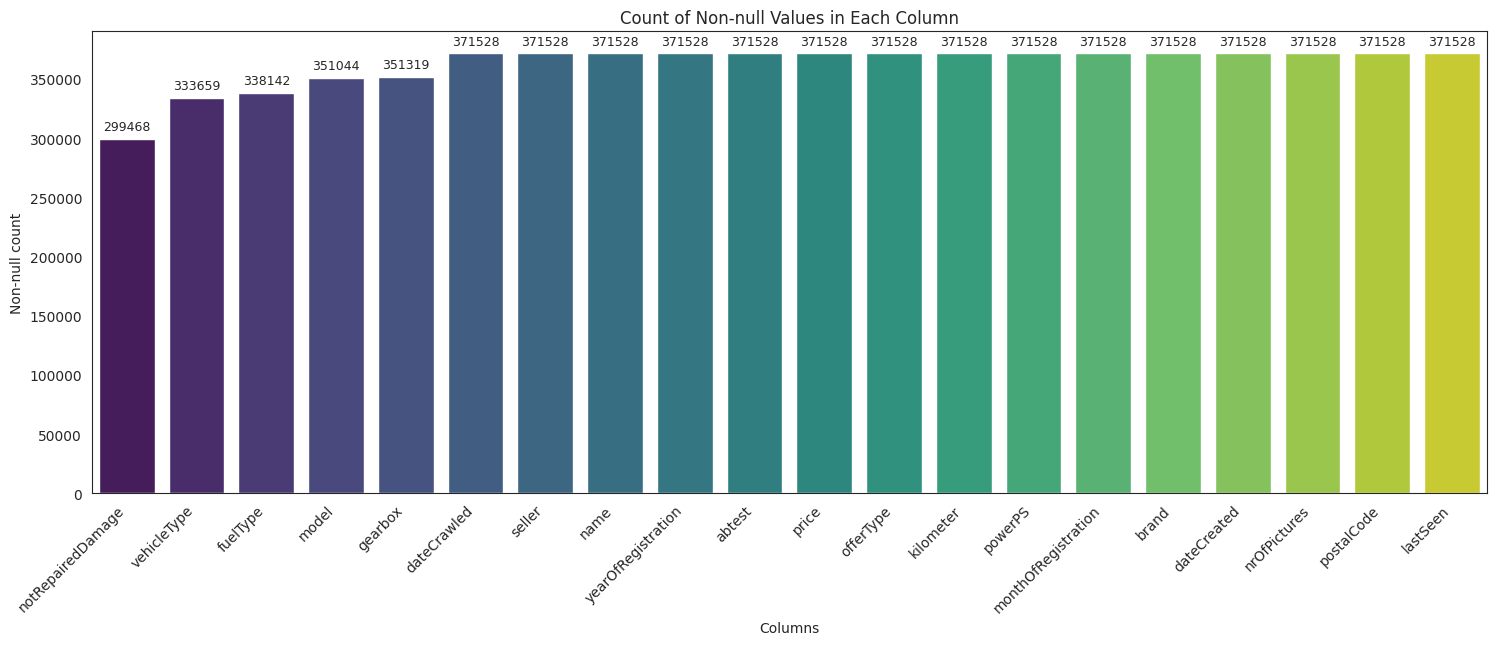

In [221]:
plt.figure(figsize=(18, 6))

notnull_counts = df.notnull().sum().sort_values(ascending=True)

fig = sns.barplot(x=notnull_counts.index, y=notnull_counts.values, palette="viridis")

for index, value in enumerate(notnull_counts.values):
    plt.text(index, value + 0.02 * max(notnull_counts.values), f"{value}", ha="center", fontsize=9)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Columns")
plt.ylabel("Non-null count")
plt.title("Count of Non-null Values in Each Column")
plt.show()

## Insights
- ### **Missing Values:**

    - **`vehicleType` has 37869 (10.2%) missing values**	
    - **`gearbox` has 20209 (5.4%) missing values**
    - **`model` has 20484 (5.5%) missing values**
    - **`fuelType` has 33386 (9.0%) missing values**
    - **`notRepairedDamage` has 72060 (19.4%) missing values**


- ### **DateTime**
    - **Dtype of `dateCrawled`. `lastSeen`, and `dateCreated` columns is object --> Convert to DateTime**
    

- ### **Zeros**

    - **`price` has 10778 (2.9%) zeros**	
    - **`powerPS` has 40820 (11.0%) zeros**
    - **`monthOfRegistration` has 37675 (10.1%) zeros**


- ### **High Correlation**

    - **`price` is highly overall correlated with `yearOfRegistration` and 1 other field**
    - **`yearOfRegistration `is highly overall correlated with `price` and 1 other field**
    - **`powerPS` is highly overall correlated with `price`	High correlation**
    - **`vehicleType` is highly overall correlated with `yearOfRegistration`**
    
- ### **Other (Possible) Problems**
    - **German categorical values --> English**
    - **`nrOfPictures` is irrelevant --> Drop**
    - **I think `dateCrawled` and `dateCreated` columns are the same (time doesn't matter here). These two, plus maybe even the `dateCreated` column are irrelevant**
    - **I don't know how I feel about the `abtest` column! is it also irrelevant?**

<Axes: title={'center': 'Test Type'}>

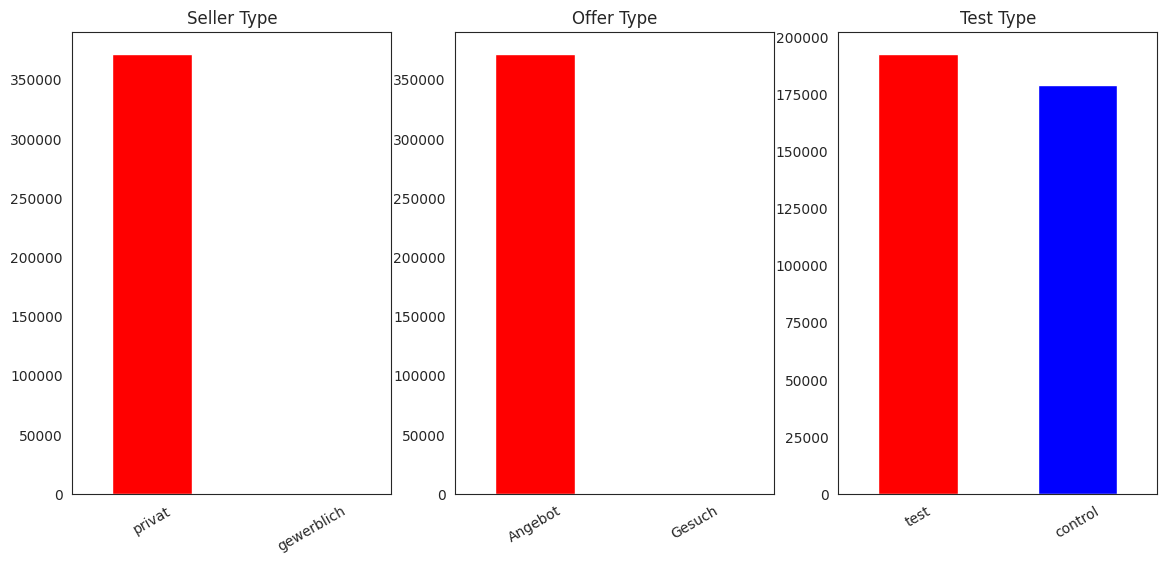

In [222]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

df["seller"].value_counts().plot(kind="bar", title="Seller Type", color=["red", "blue"], ax=axes[0], rot=30, xlabel="")

df["offerType"].value_counts().plot(
    kind="bar", title="Offer Type", color=["red", "blue"], ax=axes[1], rot=30, xlabel=""
)

df["abtest"].value_counts().plot(kind="bar", title="Test Type", color=["red", "blue"], ax=axes[2], rot=30, xlabel="")

## Data Preprocessing
- #### **I think later I'm gonna have to do more data preprocessing.**
- #### **Since except for 3 rows all the other ads are private, I'm also gonna drop the `seller` column. It's basically useless.**
- #### **As shown, the `offerTyple` column is also useless so I'm gonna drop this one, too.**
- #### **Also, I noticed that the `yearOfRegistration` column has some odd and extreme values. So, I'm gonna define a solid range for this field. I think a range between `1980` and `2023` is decent.**
- #### I will use Label Encoding for the categorical columns which only have 2 unique values such as **abtest**, **gearbox**, **notRepairedDamge**. For the other columns, I will use One-Hot Encoding.
- #### **German to English:**
    - **manuell --> Manual**
    - **automatik --> Automatic**
    - **ja --> Yes**
    - **nein --> No**
    - **benzin --> Petrol**
    - **andere --> Other**
    

In [223]:
# 1. DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(["lastSeen", "dateCrawled"], axis=1, inplace=True)
df["dateCreated"] = pd.to_datetime(df["dateCreated"])

# 2. Drop the 'nrOfPictures', 'seller', 'offerType' columns
df.drop("nrOfPictures", axis=1, inplace=True)
df.drop("seller", axis=1, inplace=True)
df.drop("offerType", axis=1, inplace=True)

# 3. Define a range for the 'yearOfRegistration'
df = df[df["yearOfRegistration"].between(1980, 2023)]

# 4. German to English, as best as I can
df["fuelType"] = df["fuelType"].map({
    "benzin": "petrol",
    "diesel": "diesel",
    "lpg": "lpg",
    "cng": "cng",
    "hybrid": "hybrid",
    "elektro": "electric",
    "andere": "other",
})
df["vehicleType"] = df["vehicleType"].map({
    "limousine": "sedan",
    "kleinwagen": "small car",
    "kombi": "station wagon",
    "bus": "bus",
    "cabrio": "convertible",
    "coupe": "coupe",
    "suv": "suv",
    "andere": "other",
})

df.head()

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode
0,Golf_3_1.6,480,test,NaN,1993,manuell,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435
1,A5_Sportback_2.7_Tdi,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,66954
2,"Jeep_Grand_Cherokee_""Overland""",9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,90480
3,GOLF_4_1_4__3TÜRER,1500,test,small car,2001,manuell,75,golf,150000,6,petrol,volkswagen,nein,2016-03-17,91074
4,Skoda_Fabia_1.4_TDI_PD_Classic,3600,test,small car,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,60437


In [224]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette("Accent", 5)

<Axes: title={'center': 'Bottom 10 Brands - Ads Count'}, xlabel='Brand', ylabel='Count'>

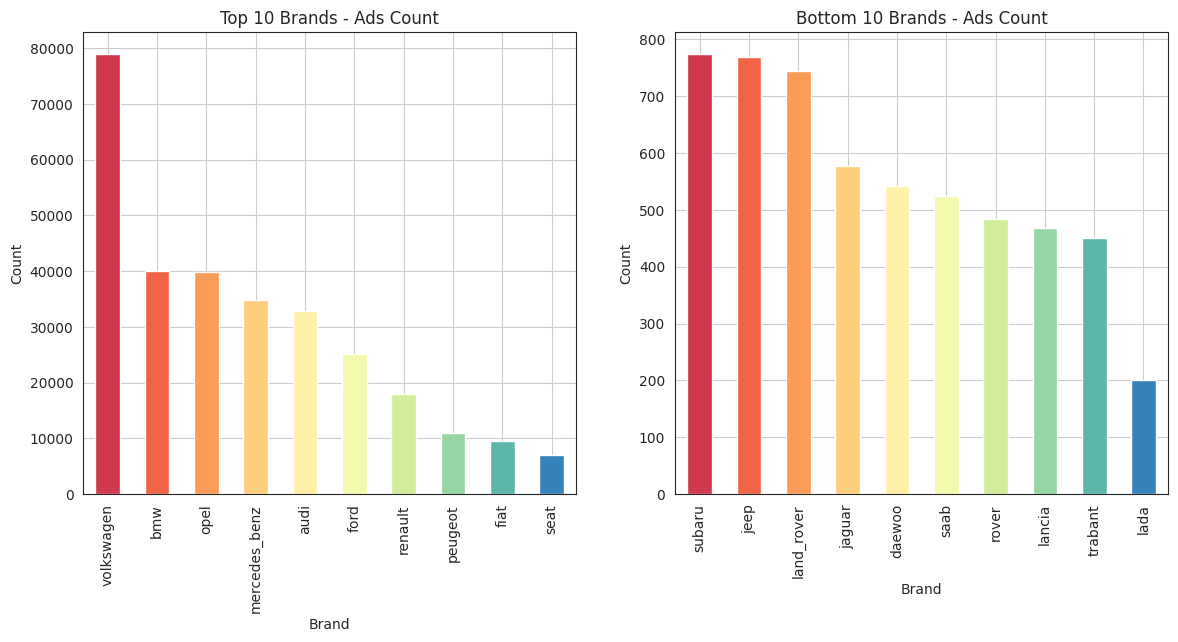

In [225]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df["brand"].value_counts().head(10).plot(
    kind="bar",
    title="Top 10 Brands - Ads Count",
    color=colors_10_1,
    ax=axes[0],
    xlabel="Brand",
    ylabel="Count",
    grid=True,
)
df["brand"].value_counts().tail(10).plot(
    kind="bar",
    title="Bottom 10 Brands - Ads Count",
    color=colors_10_1,
    ax=axes[1],
    xlabel="Brand",
    ylabel="Count",
    grid=True,
)

<Axes: title={'center': 'Bottom 10 Models by Brand - Ads Count'}, xlabel='(Brand, Model) Pairs', ylabel='Count'>

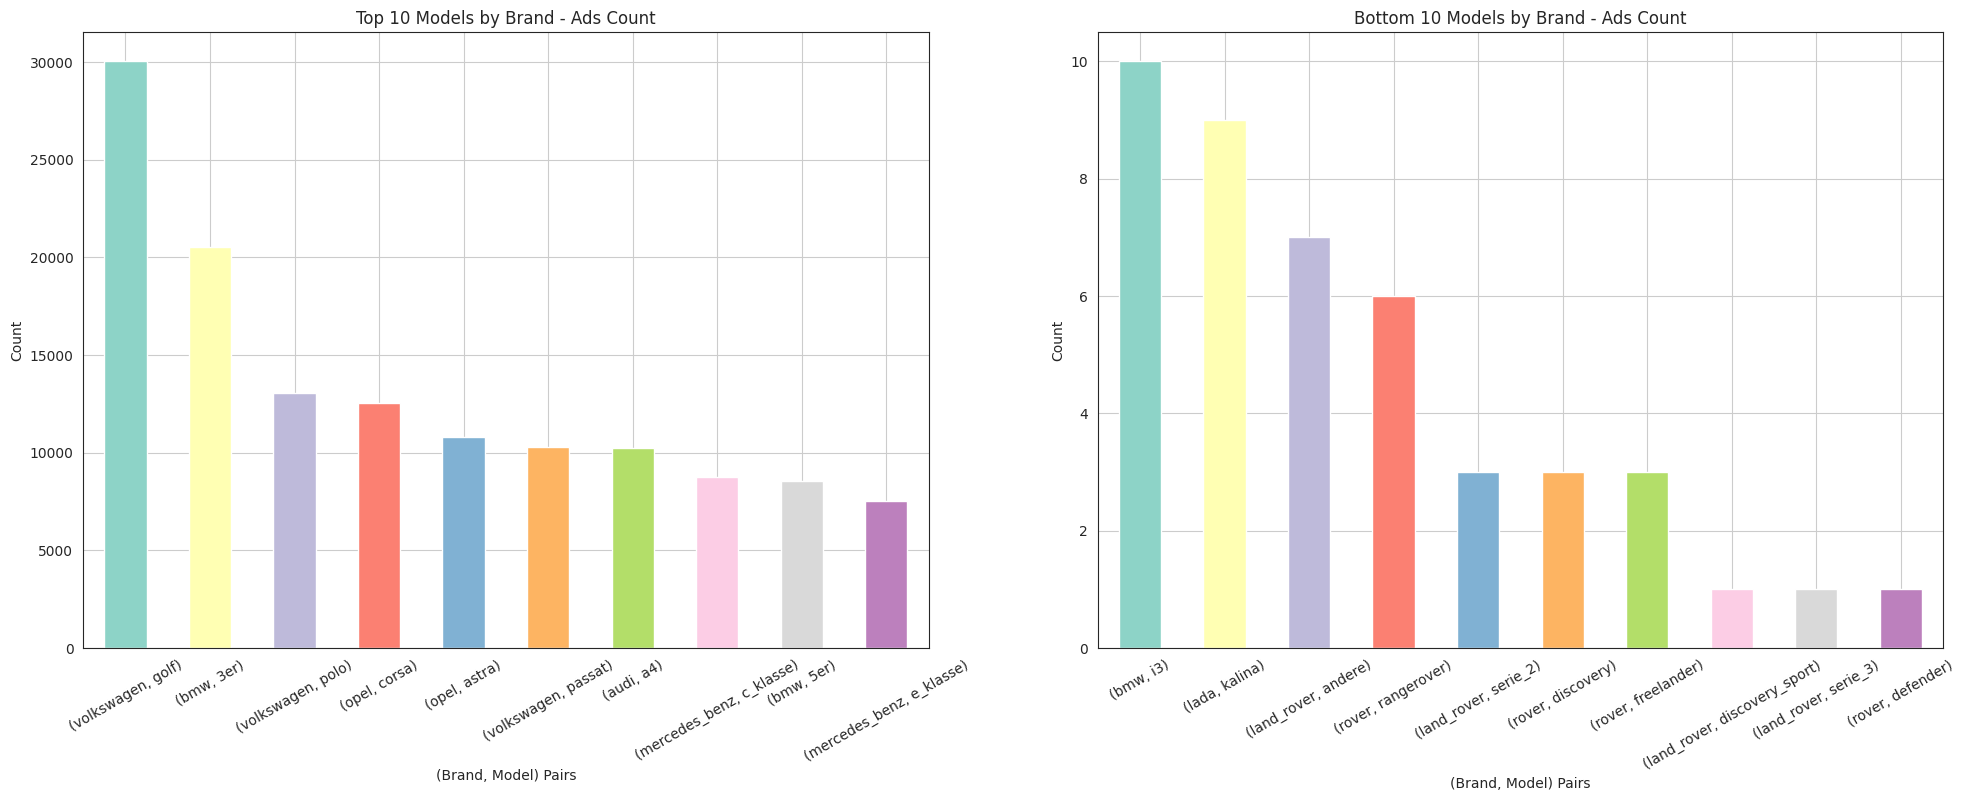

In [226]:
group_by_brand = df.groupby("brand")["model"].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

group_by_brand.head(10).plot(
    kind="bar",
    grid=True,
    rot=30,
    xlabel="(Brand, Model) Pairs",
    ylabel="Count",
    title="Top 10 Models by Brand - Ads Count",
    ax=axes[0],
    color=colors_10_2,
)
group_by_brand.tail(10).plot(
    kind="bar",
    grid=True,
    rot=30,
    xlabel="(Brand, Model) Pairs",
    ylabel="Count",
    title="Bottom 10 Models by Brand - Ads Count",
    ax=axes[1],
    color=colors_10_2,
)

<Axes: title={'center': 'Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count'}, xlabel='vehicleType,model,brand'>

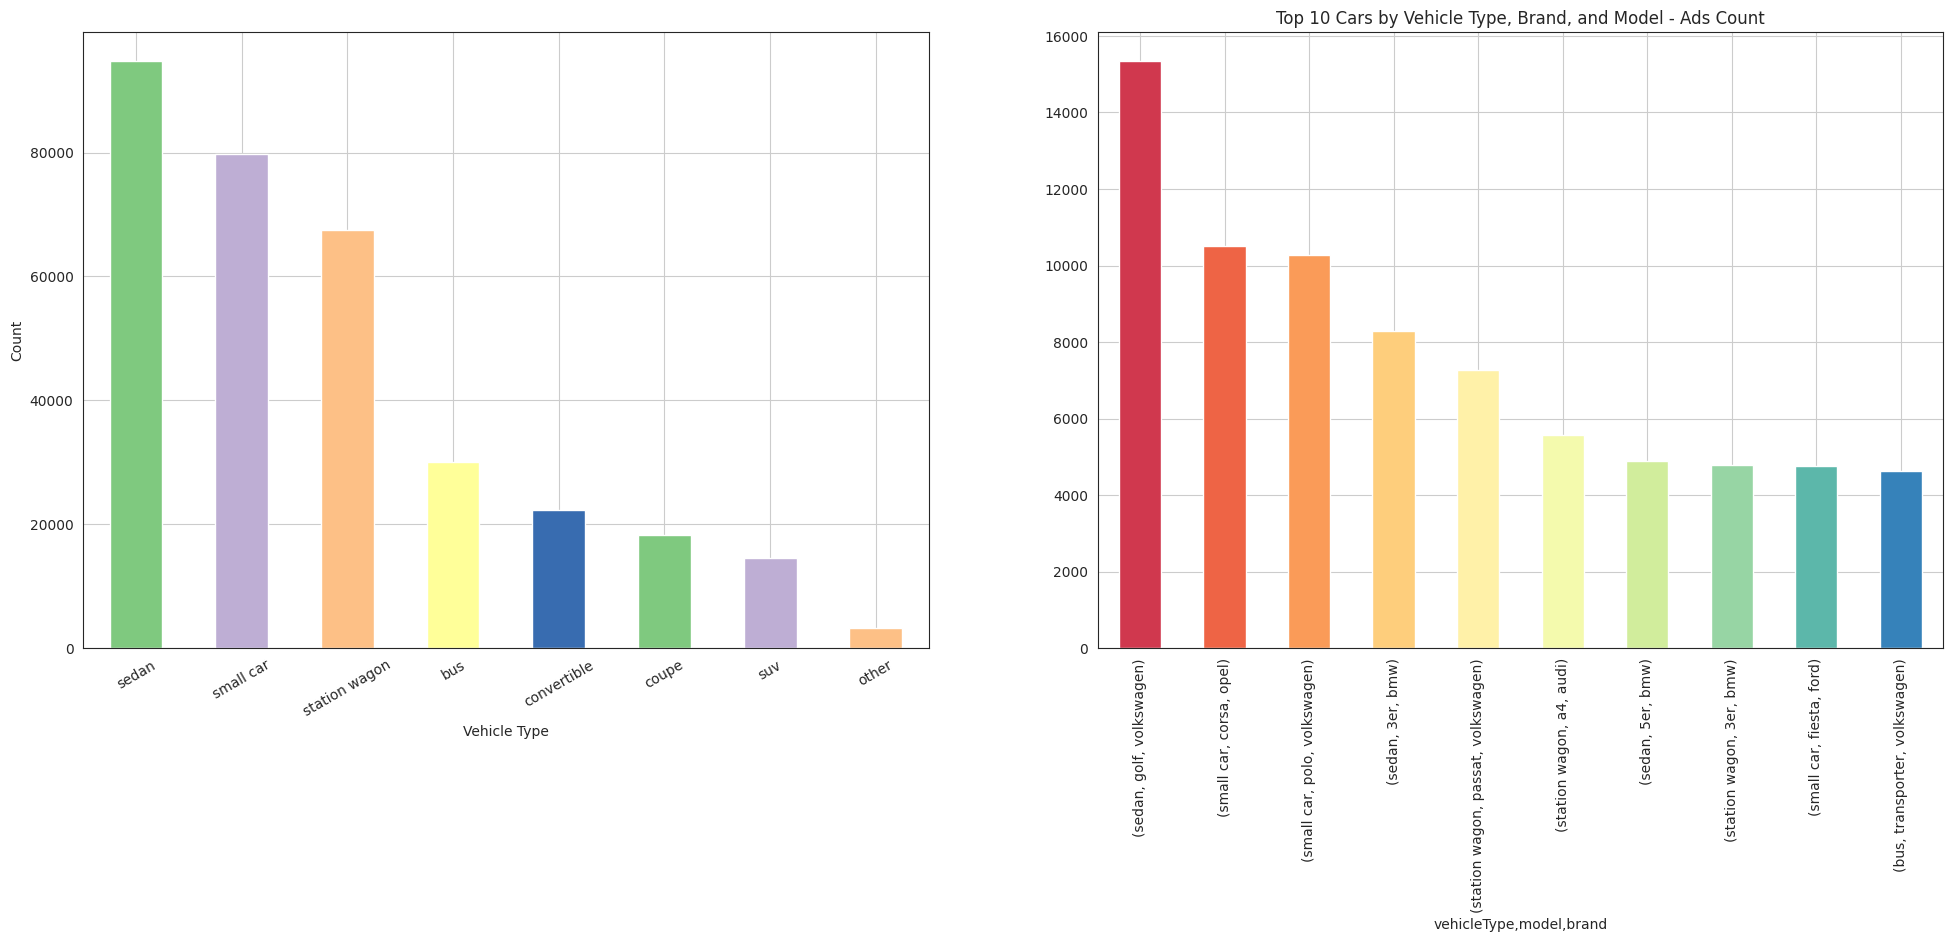

In [227]:
group_by_vehicle_type = df.groupby("vehicleType")[["model", "brand"]].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

df["vehicleType"].value_counts().plot(
    kind="bar", color=colors_5, ax=axes[0], grid=True, rot=30, xlabel="Vehicle Type", ylabel="Count", title=""
)
group_by_vehicle_type.head(10).plot(
    kind="bar",
    grid=True,
    color=colors_10_1,
    ax=axes[1],
    title="Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count",
)

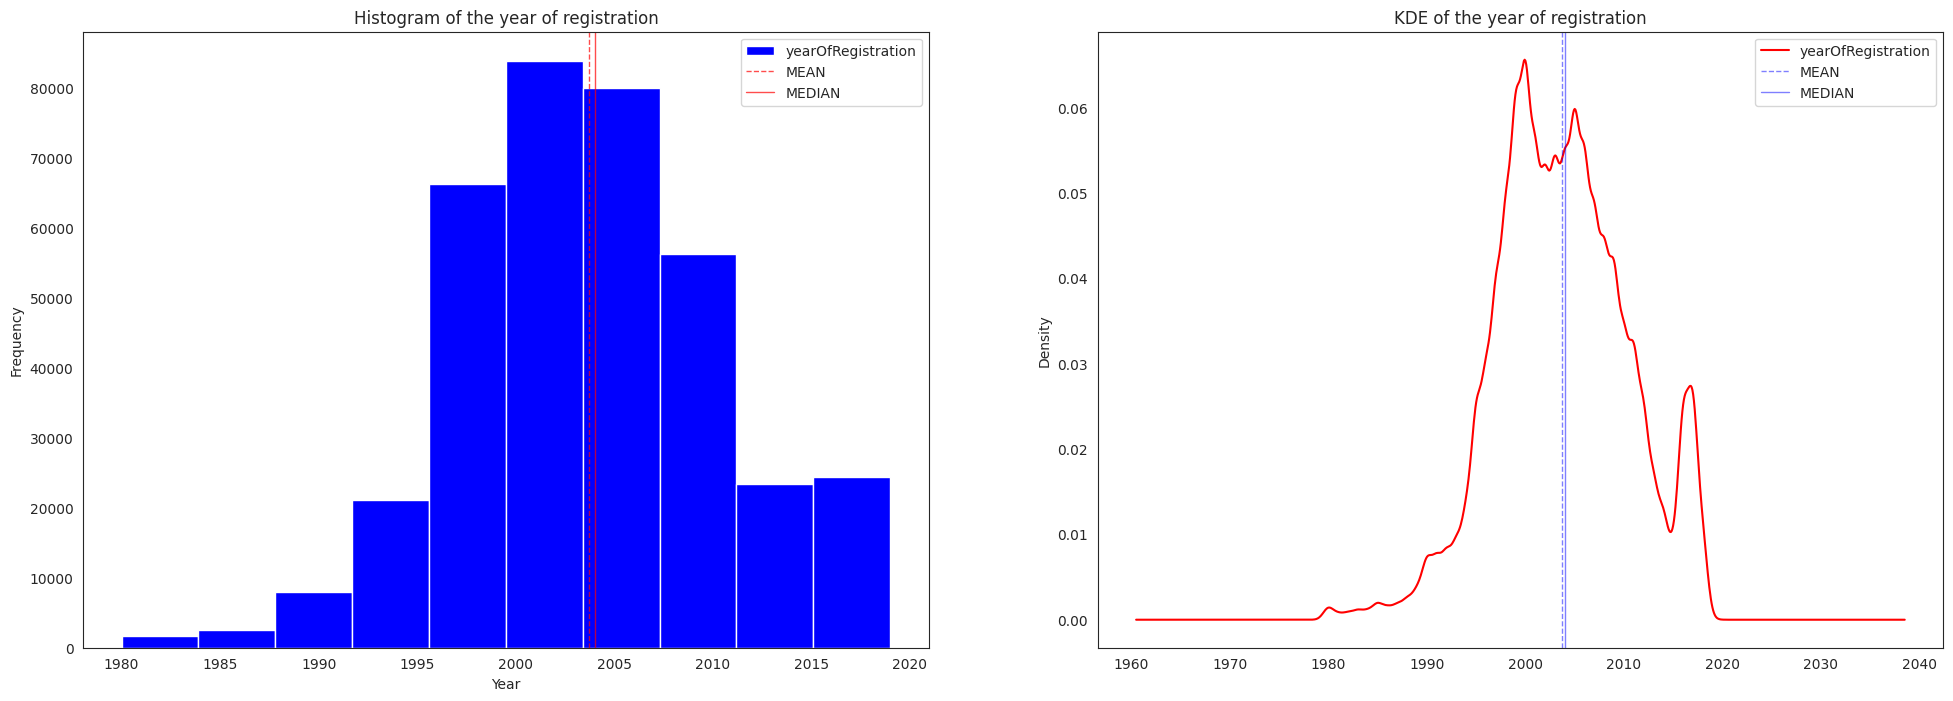

In [228]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

yr_mean = df["yearOfRegistration"].mean()
yr_median = df["yearOfRegistration"].median()

df["yearOfRegistration"].plot(
    kind="hist", bins=10, ax=axes[0], title="Histogram of the year of registration", xlabel="Year", color="blue"
)
axes[0].axvline(yr_mean, color="red", linestyle="dashed", linewidth=1, label="MEAN", alpha=0.7)
axes[0].axvline(yr_median, color="red", linestyle="solid", linewidth=1, label="MEDIAN", alpha=0.7)
axes[0].legend()

df["yearOfRegistration"].plot(
    kind="kde", ax=axes[1], title="KDE of the year of registration", xlabel="Year", color="red"
)
axes[1].axvline(yr_mean, color="blue", linestyle="dashed", linewidth=1, label="MEAN", alpha=0.5)
axes[1].axvline(yr_median, color="blue", linestyle="solid", linewidth=1, label="MEDIAN", alpha=0.5)
axes[1].legend()

### **I think there's also smth wrong with the `kilometer` field. As illustrated, the distribution is centered around `150K`. Also, there are no values higher than this. Plus, I think the values are not variable. Either way, I will leave this field alone and just use it as is.**
**Min. of Kilometer: 5,000 -- Max. of Kilometer: 150,000**

Min. of Kilometer: 5000 -- Max. of Kilometer: 150000



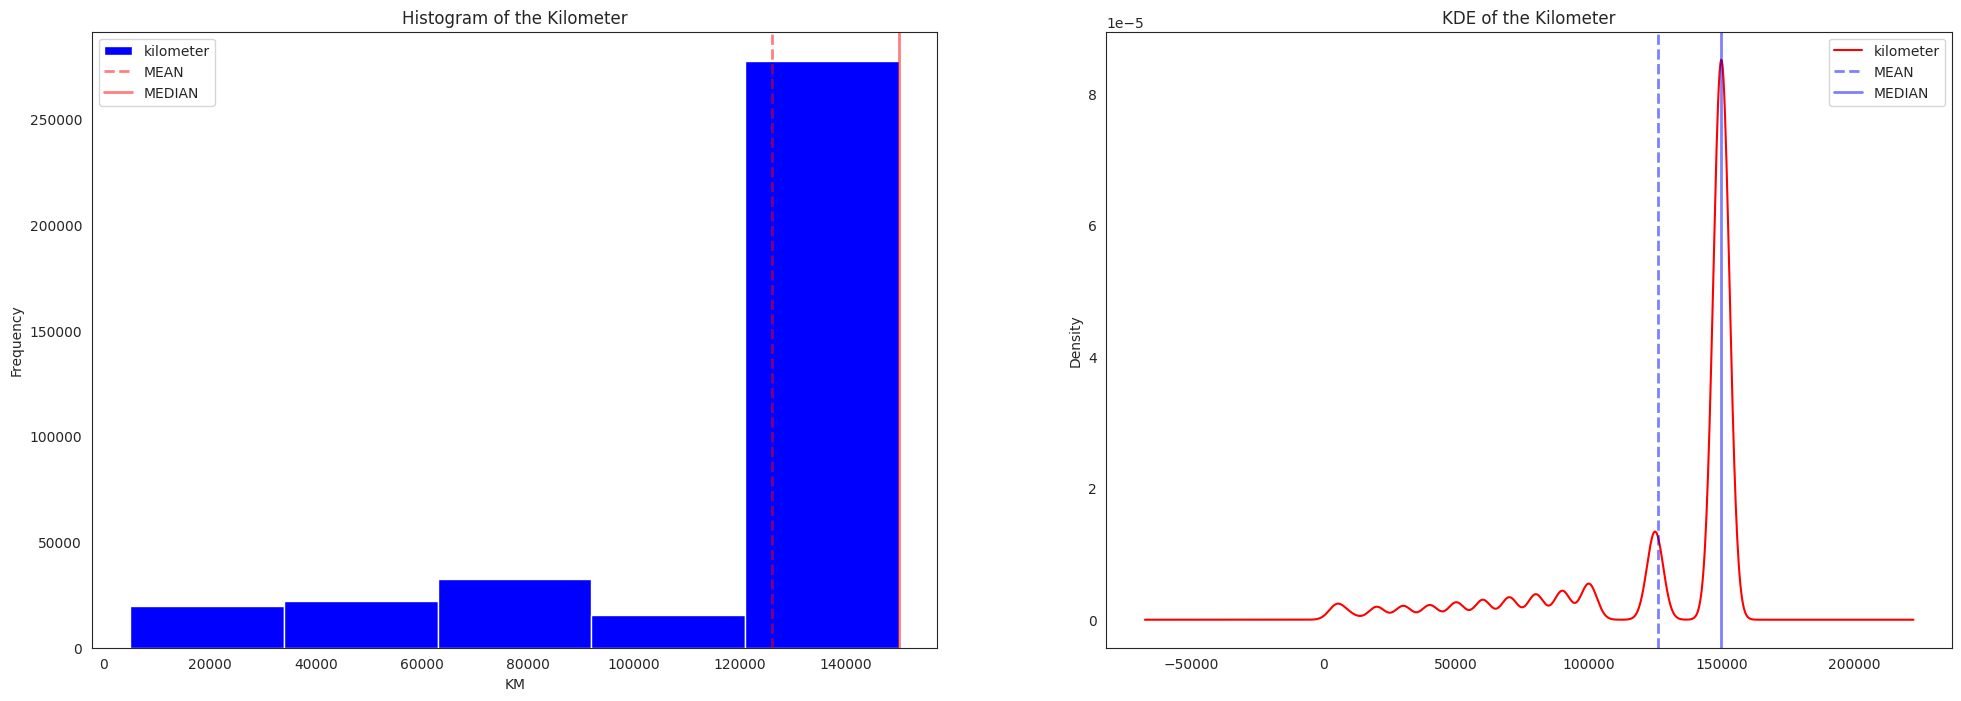

In [229]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

km_mean = df["kilometer"].mean()
km_median = df["kilometer"].median()

df["kilometer"].plot(kind="hist", bins=5, ax=axes[0], title="Histogram of the Kilometer", xlabel="KM", color="blue")
axes[0].axvline(km_mean, color="red", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[0].axvline(km_median, color="red", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[0].legend()

df["kilometer"].plot(kind="kde", ax=axes[1], title="KDE of the Kilometer", xlabel="KM", color="red")
axes[1].axvline(km_mean, color="blue", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[1].axvline(km_median, color="blue", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[1].legend()

print(f"Min. of Kilometer: {df['kilometer'].min()} -- Max. of Kilometer: {df['kilometer'].max()}\n")

### **I think I should drop rows with the fuel types of `lpg`, `cng`, `hybrid`, `other` and `elektro`.**

<Axes: title={'center': 'Repaired/Damaged?'}, xlabel='Repaired/Damaged', ylabel='Count'>

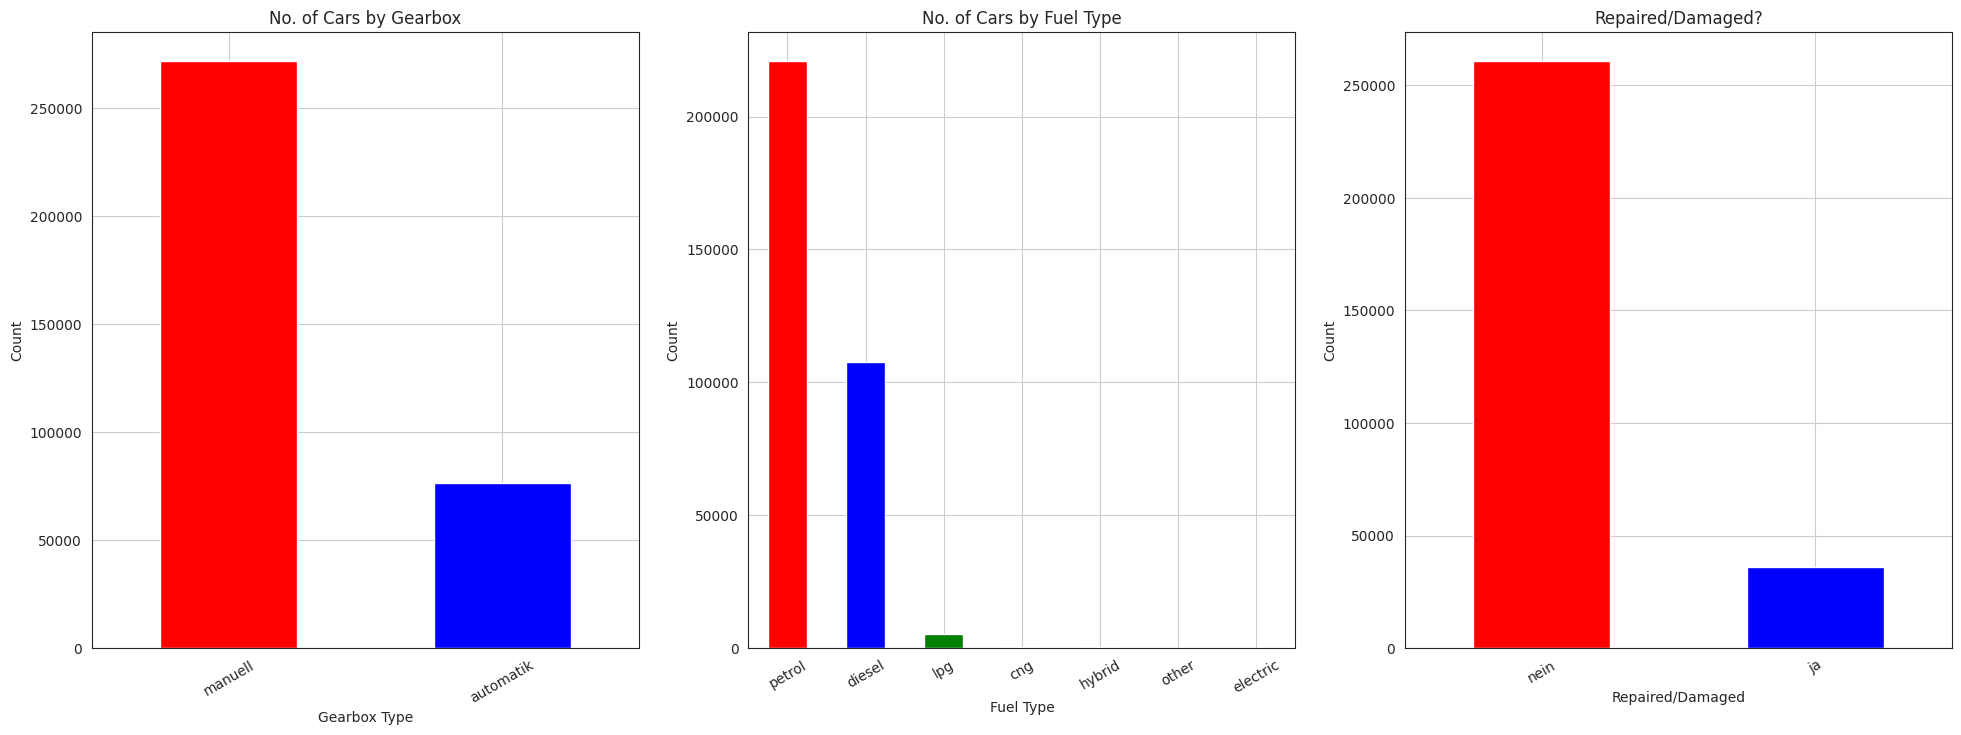

In [230]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))

df["gearbox"].value_counts().plot(
    kind="bar",
    ax=axes[0],
    color=["red", "blue"],
    title="No. of Cars by Gearbox",
    xlabel="Gearbox Type",
    ylabel="Count",
    rot=30,
    grid=True,
)
df["fuelType"].value_counts().plot(
    kind="bar",
    ax=axes[1],
    color=["red", "blue", "green", "purple"],
    title="No. of Cars by Fuel Type",
    xlabel="Fuel Type",
    ylabel="Count",
    rot=30,
    grid=True,
)
df["notRepairedDamage"].value_counts().plot(
    kind="bar",
    ax=axes[2],
    color=["red", "blue", "green"],
    title="Repaired/Damaged?",
    xlabel="Repaired/Damaged",
    ylabel="Count",
    rot=30,
    grid=True,
)

<Axes: title={'center': 'KDE of the month of registration'}, ylabel='Density'>

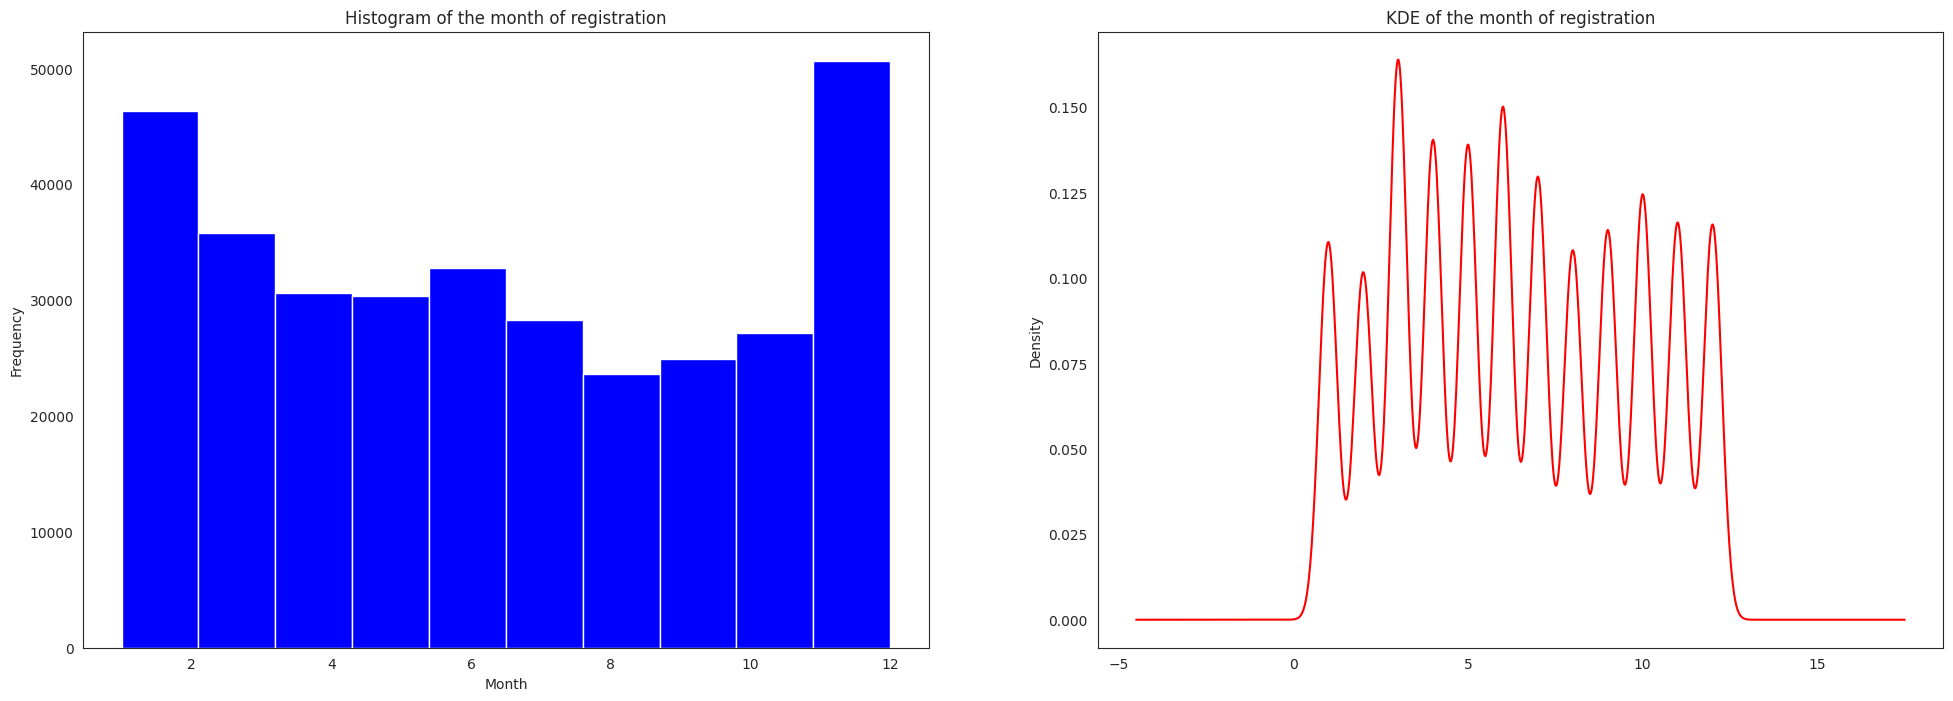

In [231]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

months = df[df["monthOfRegistration"] > 0]

months["monthOfRegistration"].plot(
    kind="hist", ax=axes[0], title="Histogram of the month of registration", xlabel="Month", color="blue"
)

months["monthOfRegistration"].plot(
    kind="kde", ax=axes[1], title="KDE of the month of registration", xlabel="Month", color="red"
)

### **There's no correlation between Price and Month of registration, so I'm gonna drop it later.**

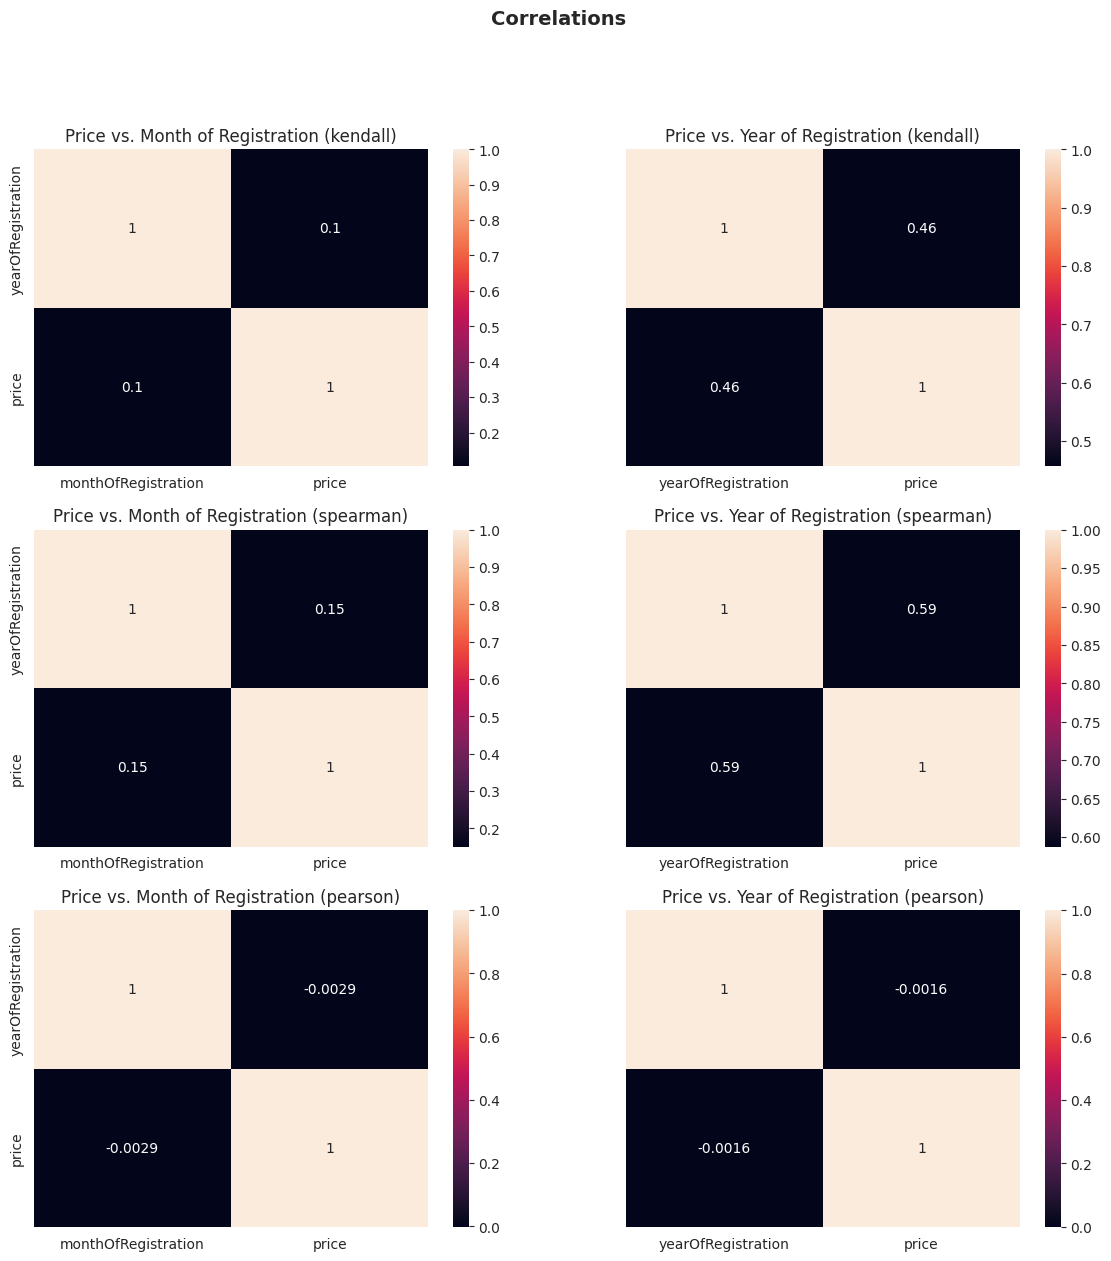

In [232]:
a = df[["monthOfRegistration", "price"]]
b = df[["yearOfRegistration", "price"]]
methods = ["kendall", "spearman", "pearson"]

fig, axes = plt.subplots(3, 2, figsize=(14, 14), sharey=True)
fig.suptitle("Correlations", fontweight="bold", fontsize="14")

for i in range(3):
    sns.heatmap(a.corr(method=methods[i]), annot=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"Price vs. Month of Registration ({methods[i]})")

    sns.heatmap(b.corr(method=methods[i]), annot=True, ax=axes[i, 1])
    axes[i, 1].set_title(f"Price vs. Year of Registration ({methods[i]})")

### **The range of the `price` bothers me:**

- **No. of cars with a price value higher than 20K: 16,469**
- **No. of cars with a price value higher than 30K: 5,556**
- **No. of cars with a price value higher than 40K: 2,501**
- **Mean of price: 16,611.7, Median of price: 2,944.0**
- **Min. price: 0, Max. price: 2,147,483,647**

In [233]:
print(f"No. of cars with a price value higher than 20K: {Style.BRIGHT}{len(df[df['price'] > 20_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 30K: {Style.BRIGHT}{len(df[df['price'] > 30_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 40K: {Style.BRIGHT}{len(df[df['price'] > 40_000])}")
print(
    f"{Style.RESET_ALL}Mean of price: {Style.BRIGHT}{df['price'].mean():.2f}{Style.RESET_ALL}, Median of price: {Style.BRIGHT}{df['price'].median()}"
)
print(
    f"{Style.RESET_ALL}Min. price: {Style.BRIGHT}{df['price'].min()}{Style.RESET_ALL}, Max. price: {Style.BRIGHT}{df['price'].max()}"
)

No. of cars with a price value higher than 20K: 16469
No. of cars with a price value higher than 30K: 5556
No. of cars with a price value higher than 40K: 2501
Mean of price: 16611.71, Median of price: 2944.0
Min. price: 0, Max. price: 2147483647


### **As shown, the range of `[200, 20K]` is better than the other two and it eliminates a largre proportion of outliers. We can go even lower, but I don't like doing so. Just remember that the prices are skewed.**

In [234]:
df["price"].quantile(0.95), df["price"].quantile(0.05)

(np.float64(19500.0), np.float64(200.0))

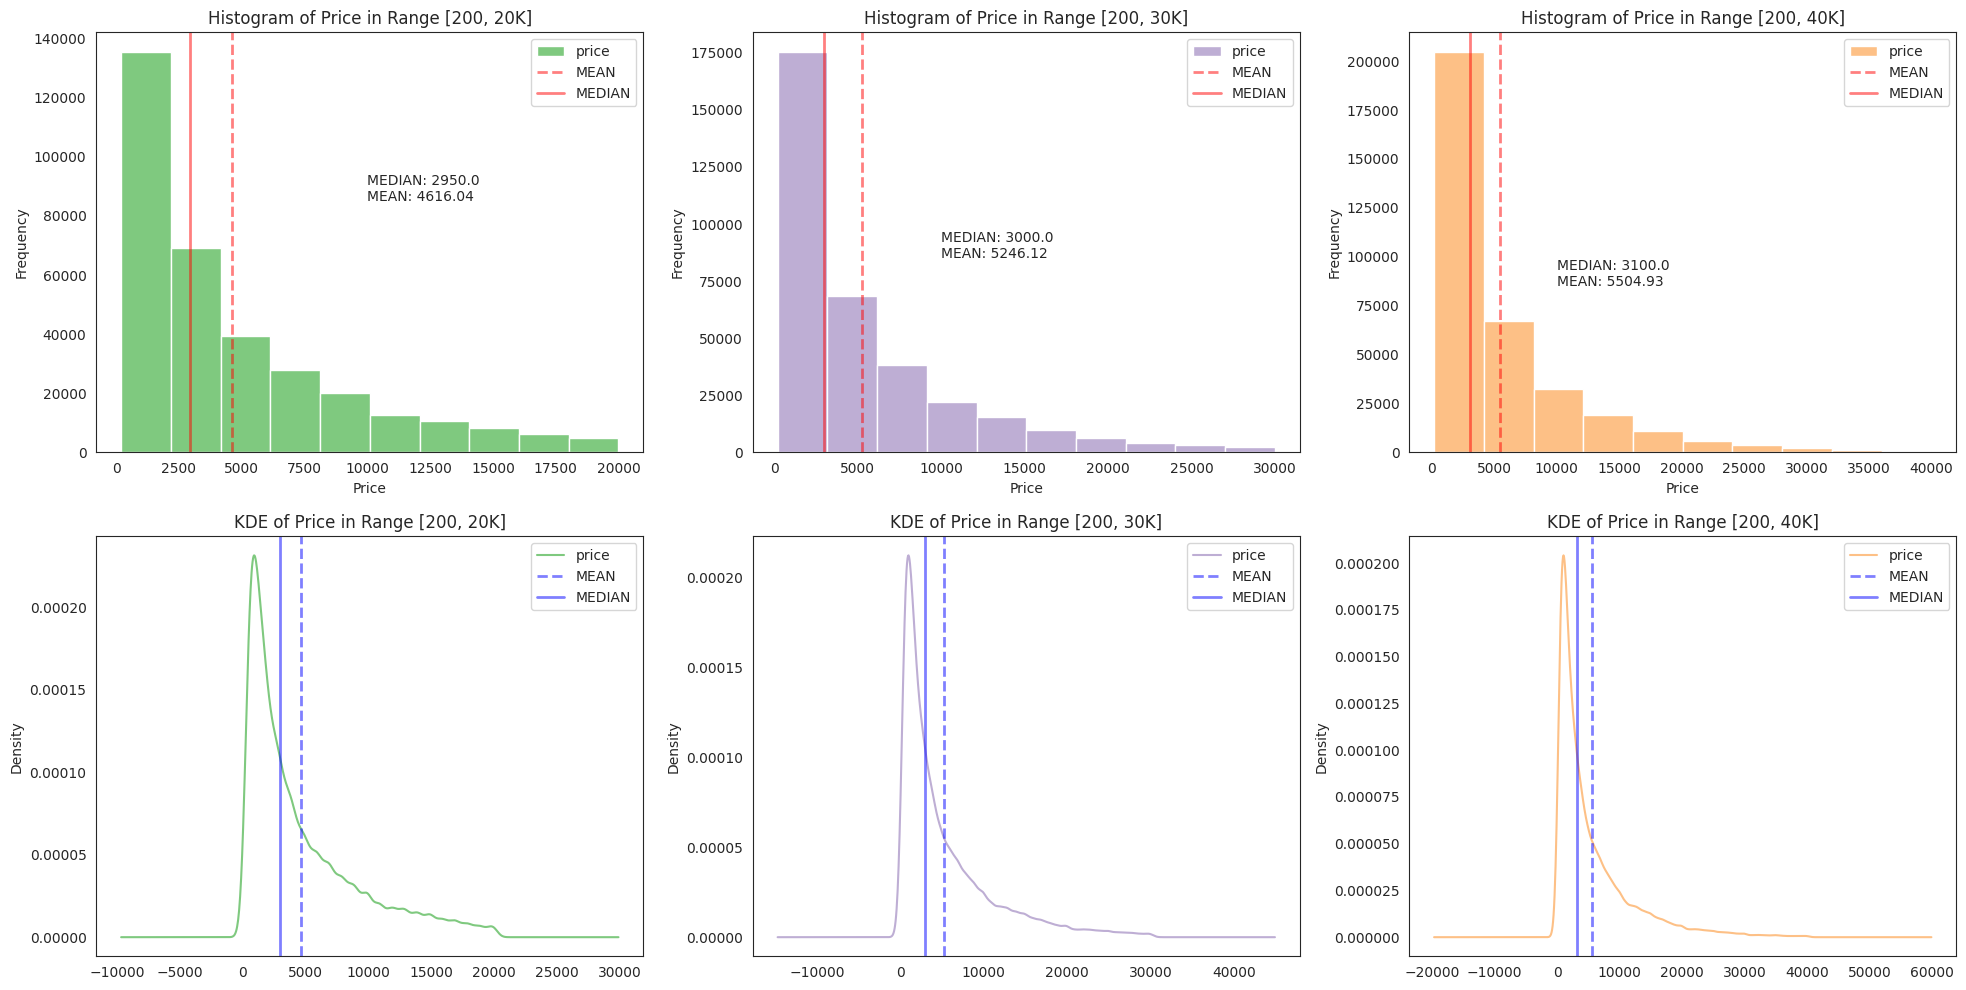

In [235]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

bins = 10

price_20 = df.loc[df["price"].between(200, 20_000), "price"]
price_30 = df.loc[df["price"].between(200, 30_000), "price"]
price_40 = df.loc[df["price"].between(200, 40_000), "price"]

price_20.plot(
    kind="hist",
    bins=bins,
    ax=axes[0, 0],
    title="Histogram of Price in Range [200, 20K]",
    xlabel="Price",
    color=colors_5[0],
)
axes[0, 0].axvline(price_20.mean(), color="red", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[0, 0].axvline(price_20.median(), color="red", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[0, 0].legend()
txt = f"MEDIAN: {price_20.median()}\nMEAN: {price_20.mean():.2f}"
axes[0, 0].text(10_000, 85_000, txt)

price_30.plot(
    kind="hist",
    bins=bins,
    ax=axes[0, 1],
    title="Histogram of Price in Range [200, 30K]",
    xlabel="Price",
    color=colors_5[1],
)
axes[0, 1].axvline(price_30.mean(), color="red", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[0, 1].axvline(price_30.median(), color="red", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[0, 1].legend()
txt = f"MEDIAN: {price_30.median()}\nMEAN: {price_30.mean():.2f}"
axes[0, 1].text(10_000, 85_000, txt)

price_40.plot(
    kind="hist",
    bins=bins,
    ax=axes[0, 2],
    title="Histogram of Price in Range [200, 40K]",
    xlabel="Price",
    color=colors_5[2],
)
axes[0, 2].axvline(price_40.mean(), color="red", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[0, 2].axvline(price_40.median(), color="red", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[0, 2].legend()
txt = f"MEDIAN: {price_40.median()}\nMEAN: {price_40.mean():.2f}"
axes[0, 2].text(10_000, 85_000, txt)

price_20.plot(kind="kde", ax=axes[1, 0], title="KDE of Price in Range [200, 20K]", xlabel="Price", color=colors_5[0])
axes[1, 0].axvline(price_20.mean(), color="blue", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[1, 0].axvline(price_20.median(), color="blue", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[1, 0].legend()

price_30.plot(kind="kde", ax=axes[1, 1], title="KDE of Price in Range [200, 30K]", xlabel="Price", color=colors_5[1])
axes[1, 1].axvline(price_30.mean(), color="blue", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[1, 1].axvline(price_30.median(), color="blue", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[1, 1].legend()

price_40.plot(kind="kde", ax=axes[1, 2], title="KDE of Price in Range [200, 40K]", xlabel="Price", color=colors_5[2])
axes[1, 2].axvline(price_40.mean(), color="blue", linestyle="dashed", linewidth=2, label="MEAN", alpha=0.5)
axes[1, 2].axvline(price_40.median(), color="blue", linestyle="solid", linewidth=2, label="MEDIAN", alpha=0.5)
axes[1, 2].legend()

- #### **Drop null values**
- #### **As mentioned above, the range of price will be set to`[200, 20K]`**
- #### **Drop the extreme values of the `powerPS`**
- #### **Drop the `postalCode`, `dateCreated`, `name`, and `monthOfRegistration` columns**
- #### **Add a new column for the `age` of the car. Then drop the `yearOfRegistration` column**

In [236]:
# drop null values
df.dropna(inplace=True)

# Drop cars with unacceptable prices
df = df[df["price"].between(200, 20_000)]

# Drop cars with extreme powerPS
df = df[(df["powerPS"] > 0) & (df["powerPS"] <= 1000)]

# Add the 'age' column
current_year = 2025
df["age"] = current_year - df["yearOfRegistration"]

# Drop unnecessary columns and rows
df.drop(["postalCode", "dateCreated", "name", "monthOfRegistration", "yearOfRegistration"], axis=1, inplace=True)
df = df[df["fuelType"] != "Other"]
df = df[df["notRepairedDamage"] != "NaN"]

In [237]:
df.head()

,price,abtest,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
3,1500,test,small car,manuell,75,golf,150000,petrol,volkswagen,nein,24
4,3600,test,small car,manuell,69,fabia,90000,diesel,skoda,nein,17
5,650,test,sedan,manuell,102,3er,150000,petrol,bmw,ja,30
6,2200,test,convertible,manuell,109,2_reihe,150000,petrol,peugeot,nein,21
10,2000,control,sedan,manuell,105,3_reihe,150000,petrol,mazda,nein,21


In [238]:
df.nunique()

price                3282
abtest                  2
vehicleType             8
gearbox                 2
powerPS               426
model                 248
kilometer              13
fuelType                7
brand                  39
notRepairedDamage       2
age                    39
dtype: int64

In [239]:
df["notRepairedDamage"] = df["notRepairedDamage"].dropna().map({"ja": 1, "nein": 0}).astype(int)
df["abtest"] = df["abtest"].map({"test": 1, "control": 0}).astype(int)
df["gearbox"] = df["gearbox"].map({"automatik": "1", "manuell": "0"}).astype(int)

In [240]:
df.head()

,price,abtest,vehicleType,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,age
3,1500,1,small car,0,75,golf,150000,petrol,volkswagen,0,24
4,3600,1,small car,0,69,fabia,90000,diesel,skoda,0,17
5,650,1,sedan,0,102,3er,150000,petrol,bmw,1,30
6,2200,1,convertible,0,109,2_reihe,150000,petrol,peugeot,0,21
10,2000,0,sedan,0,105,3_reihe,150000,petrol,mazda,0,21


#### - **I think the data itself is quite ready for this phase. However, I should apply Feature Scaling with Z-Score Norm**
#### - **I will also split the data with a ratio of %70, %15, and %15.**

In [241]:
numerical_features = ["kilometer", "powerPS", "age"]
categorical_features = ["vehicleType", "fuelType", "brand", "model"]

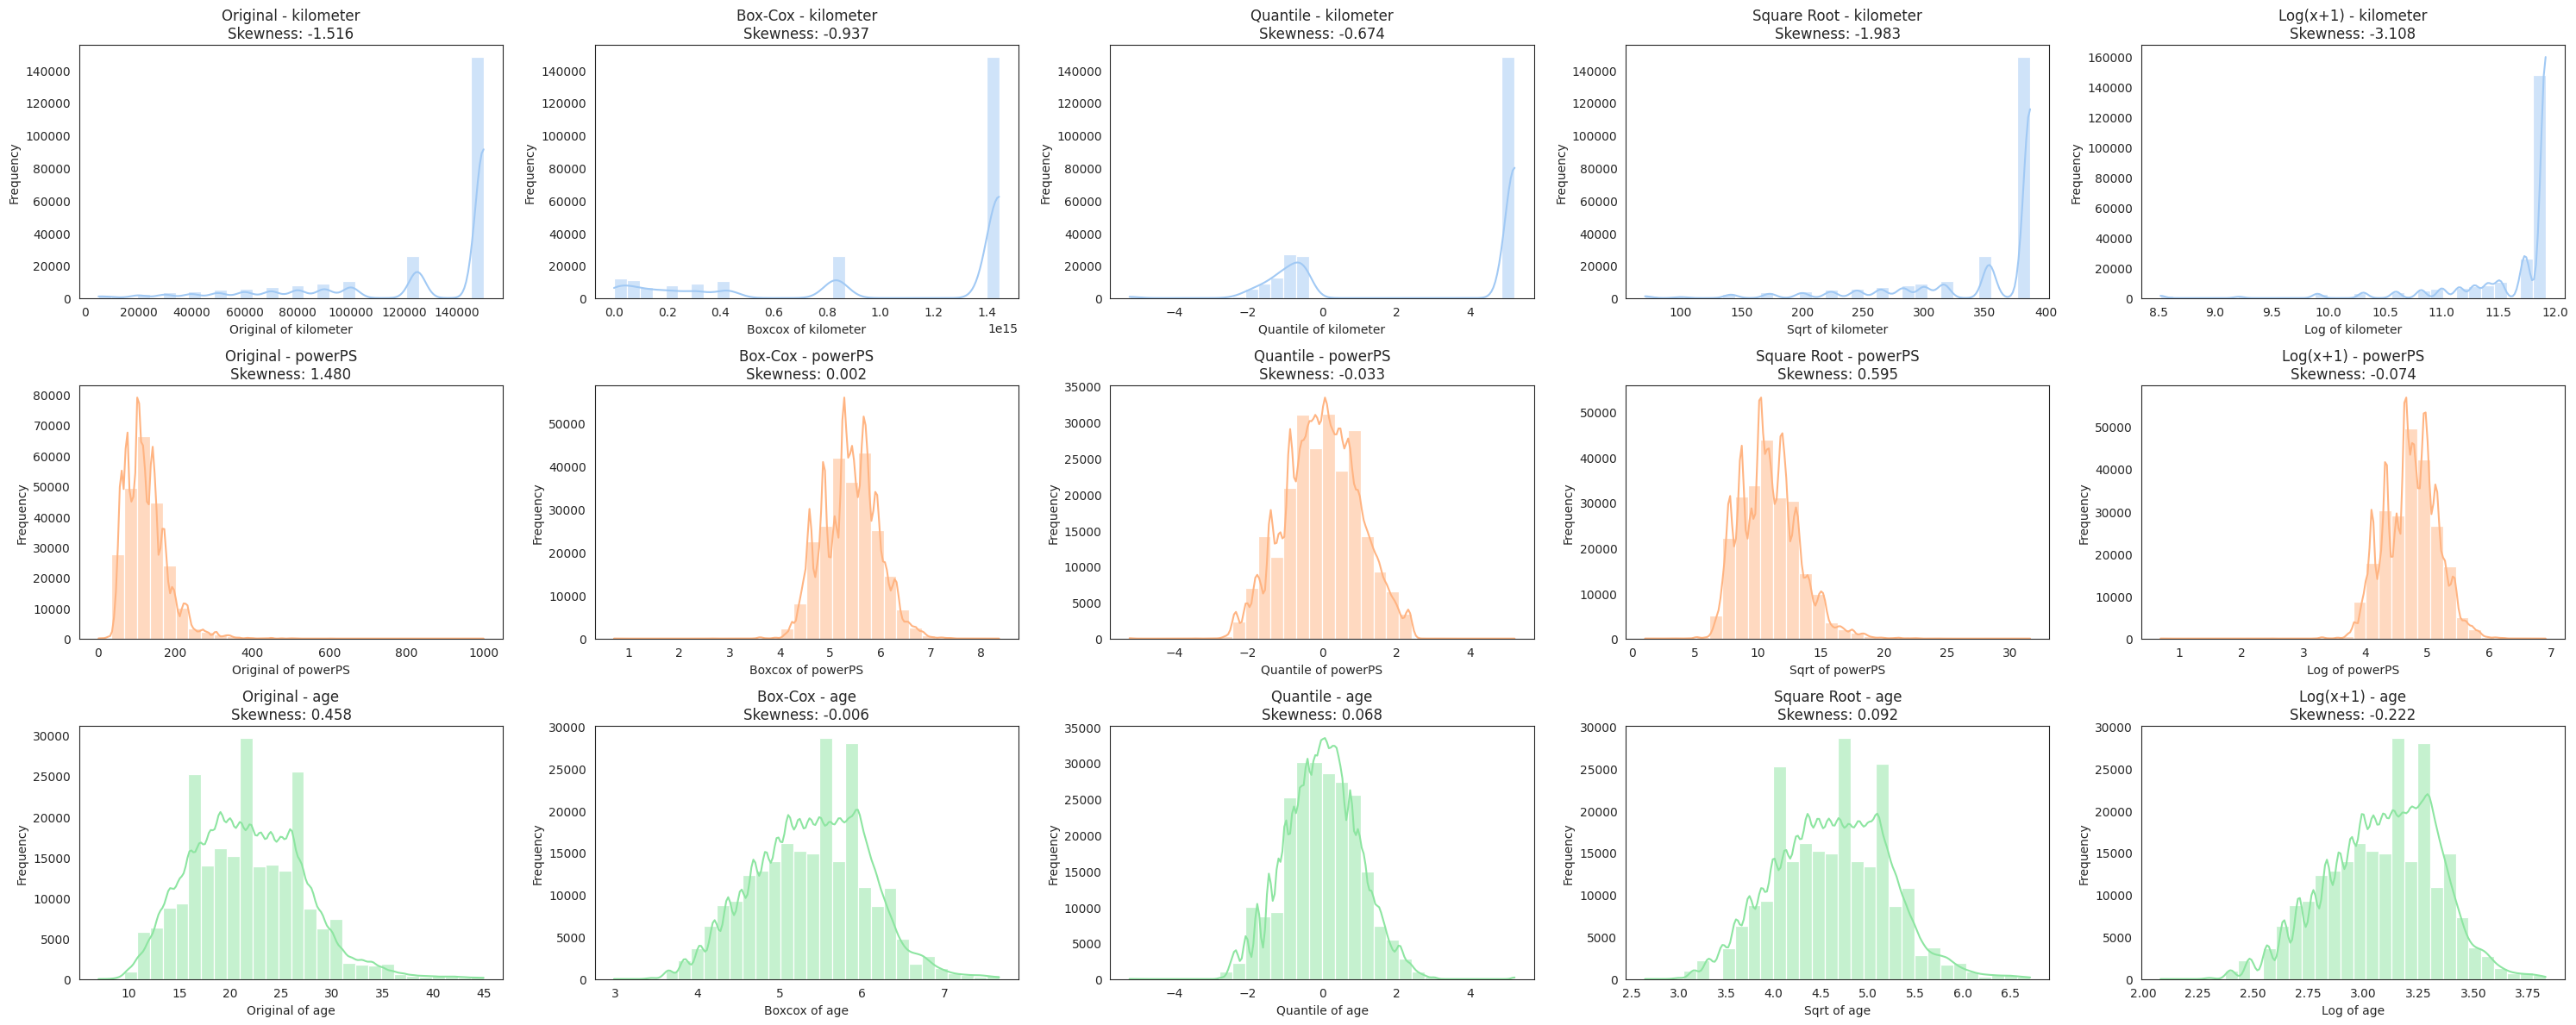

In [ ]:
color_palette = sns.color_palette("pastel")

trans_col = ["original", "boxcox", "quantile", "sqrt", "log"]


def plot_transformations(df, features, transformations=None):
    if transformations is None:
        transformations = ["original", "boxcox", "quantile", "sqrt", "log"]

    n_features = len(features)
    n_transforms = len(transformations)

    fig, axes = plt.subplots(n_features, n_transforms, figsize=(n_transforms * 6, n_features * 4))

    for i, feature in enumerate(features):
        for j, transform in enumerate(transformations):
            ax = axes[i, j] if n_features > 1 else axes[j]

            if transform == "original":
                data = df[feature]
                title = f"Original - {feature}"
            elif transform == "boxcox":
                data, _ = boxcox(df[feature] + 1)
                title = f"Box-Cox - {feature}"
            elif transform == "quantile":
                transformer = QuantileTransformer(n_quantiles=100, output_distribution="normal")
                data = transformer.fit_transform(df[feature].values.reshape(-1, 1)).flatten()
                title = f"Quantile - {feature}"
            elif transform == "sqrt":
                data = np.sqrt(df[feature])
                title = f"Square Root - {feature}"
            elif transform == "log":
                data = np.log1p(df[feature])
                title = f"Log(x+1) - {feature}"

            skewness = stats.skew(data)

            sns.histplot(data, kde=True, bins=30, ax=ax, color=color_palette[i])
            ax.set_title(f"{title}\nSkewness: {skewness:.3f}")
            ax.set_xlabel(f"{transform.capitalize()} of {feature}")
            ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


plot_transformations(df, numerical_features)

We can apply normalization techniques to turn data distribution near to Guassian distribution

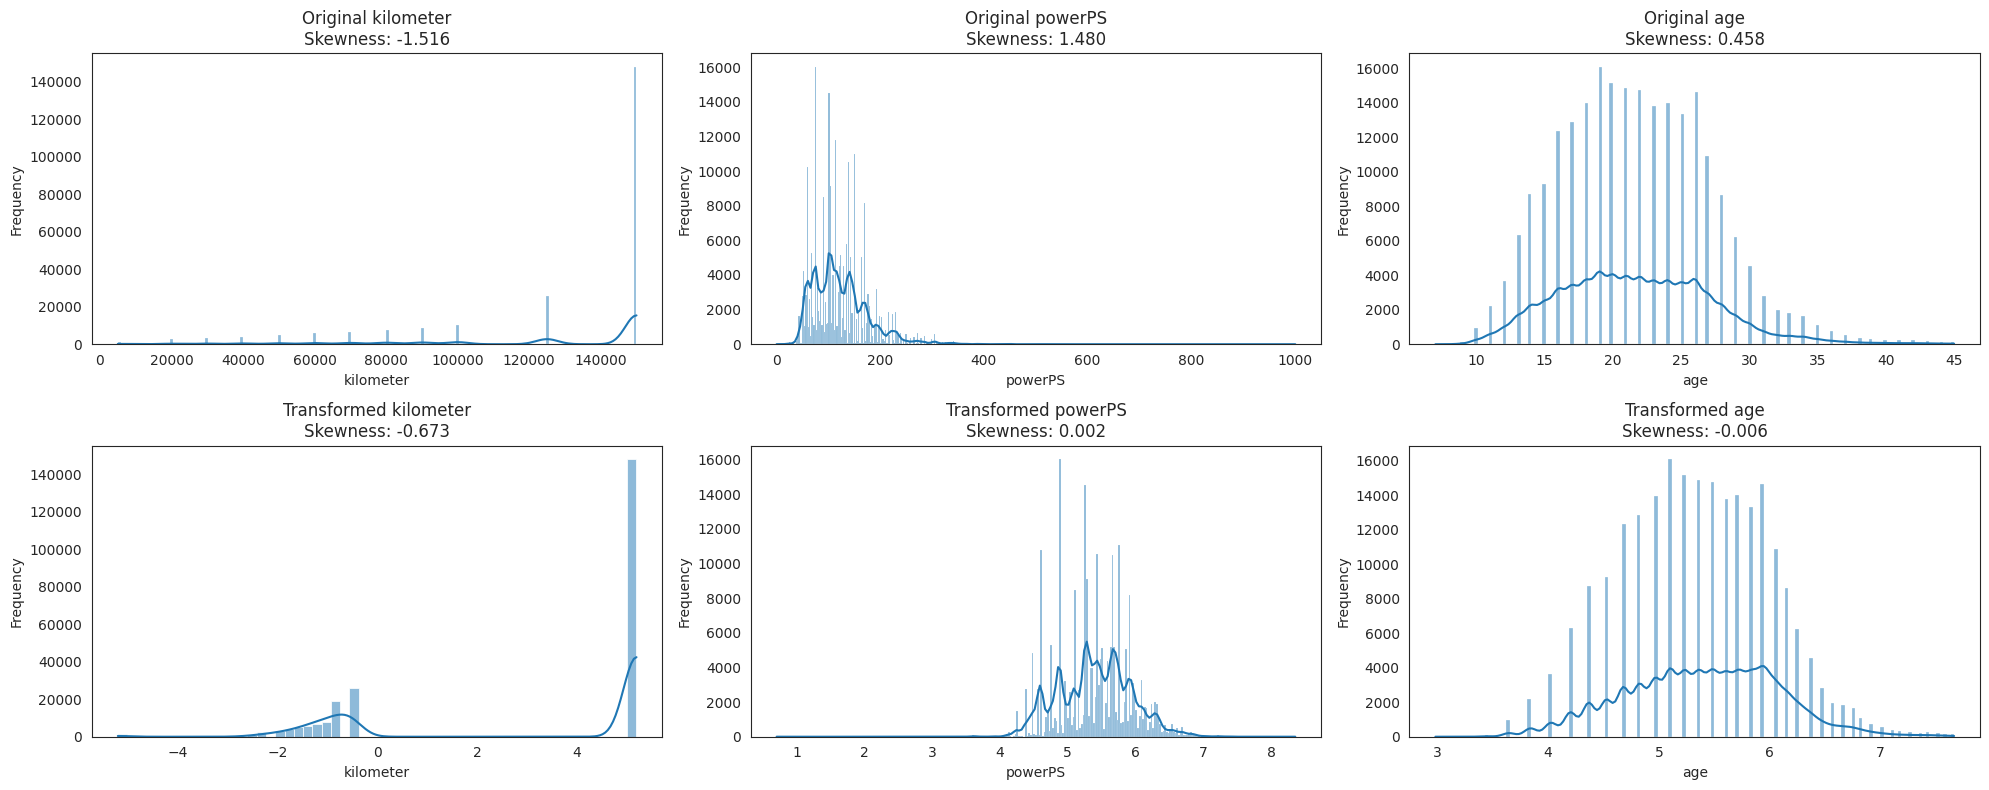

In [243]:
df_transformed = df.copy()

qt = QuantileTransformer(output_distribution="normal")
df_transformed["kilometer"] = qt.fit_transform(df[["kilometer"]])


for col in ["powerPS", "age"]:
    df_transformed[col], _ = boxcox(df[col] + 1)


fig, axes = plt.subplots(2, len(numerical_features), figsize=(20, 8))

for i, col in enumerate(numerical_features):
    sns.histplot(df[col], kde=True, ax=axes[0, i])
    axes[0, i].set_title(f"Original {col}\nSkewness: {stats.skew(df[col]):.3f}")
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel("Frequency")

    sns.histplot(df_transformed[col], kde=True, ax=axes[1, i])
    axes[1, i].set_title(f"Transformed {col}\nSkewness: {stats.skew(df_transformed[col]):.3f}")
    axes[1, i].set_xlabel(col)
    axes[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

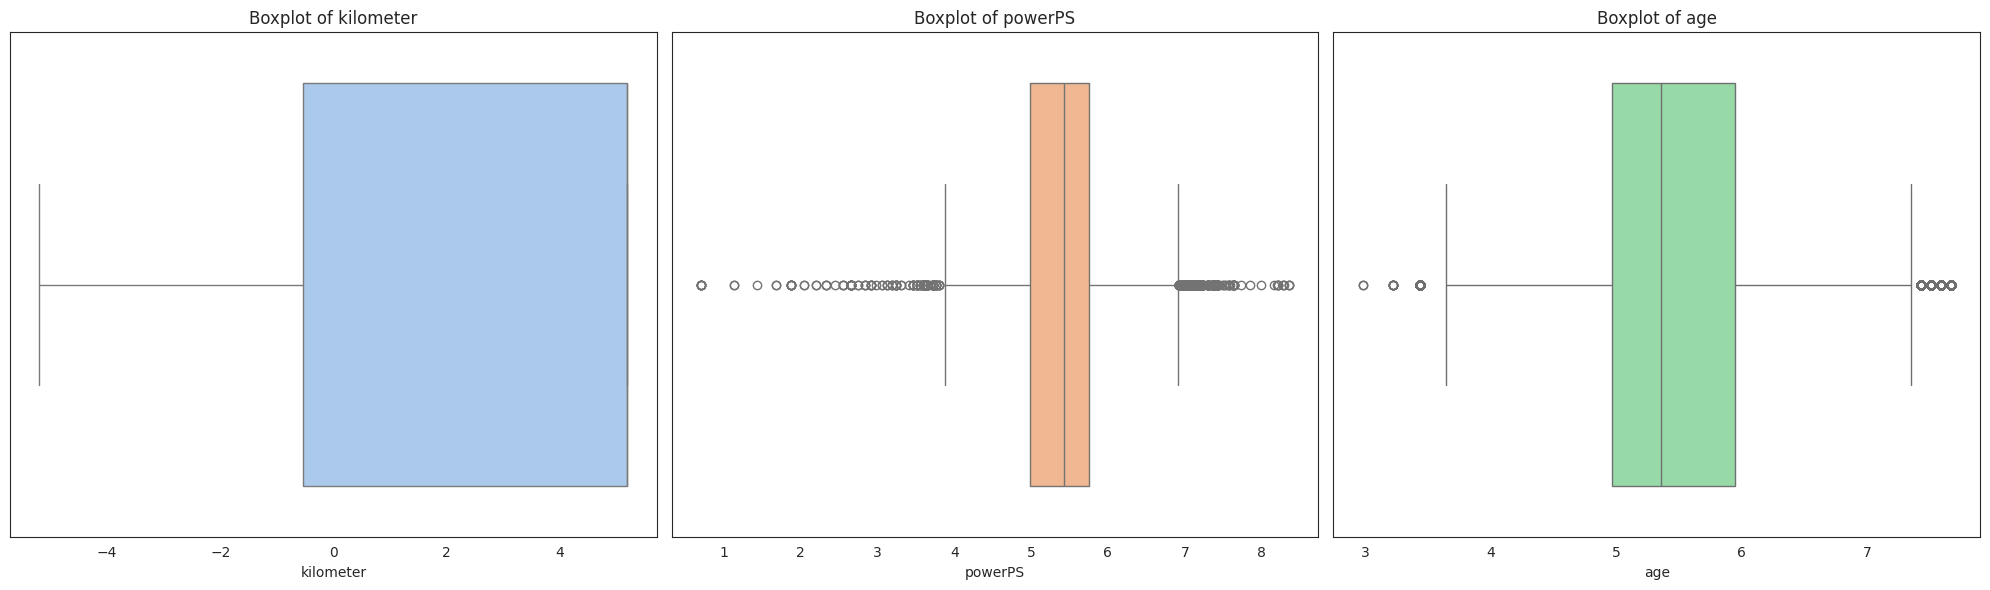

In [244]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), tight_layout=True)
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

for i, column in enumerate(numerical_features):
    sns.boxplot(x=df_transformed[column], ax=axes[i], color=color_palette[i])
    axes[i].set_title(f"Boxplot of {column}")
    axes[i].set_xlabel(column)

plt.show()

In [245]:
def IQR_limits(df, features):
    df_clean = df.copy()

    for feature in features:
        Q1 = df_clean[feature].quantile(0.25)
        Q3 = df_clean[feature].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)
        print(f"Number of outliers in '{feature}' column: {outliers.sum()}")

        df_clean = df_clean[~outliers]

    return df_clean

PowerPS have a large number of outliers, so we should consider remove outliers in this feature.

In [246]:
df_test = df_transformed.copy(deep=True)
df_test = IQR_limits(df_test, ["powerPS"])

Number of outliers in 'powerPS' column: 795


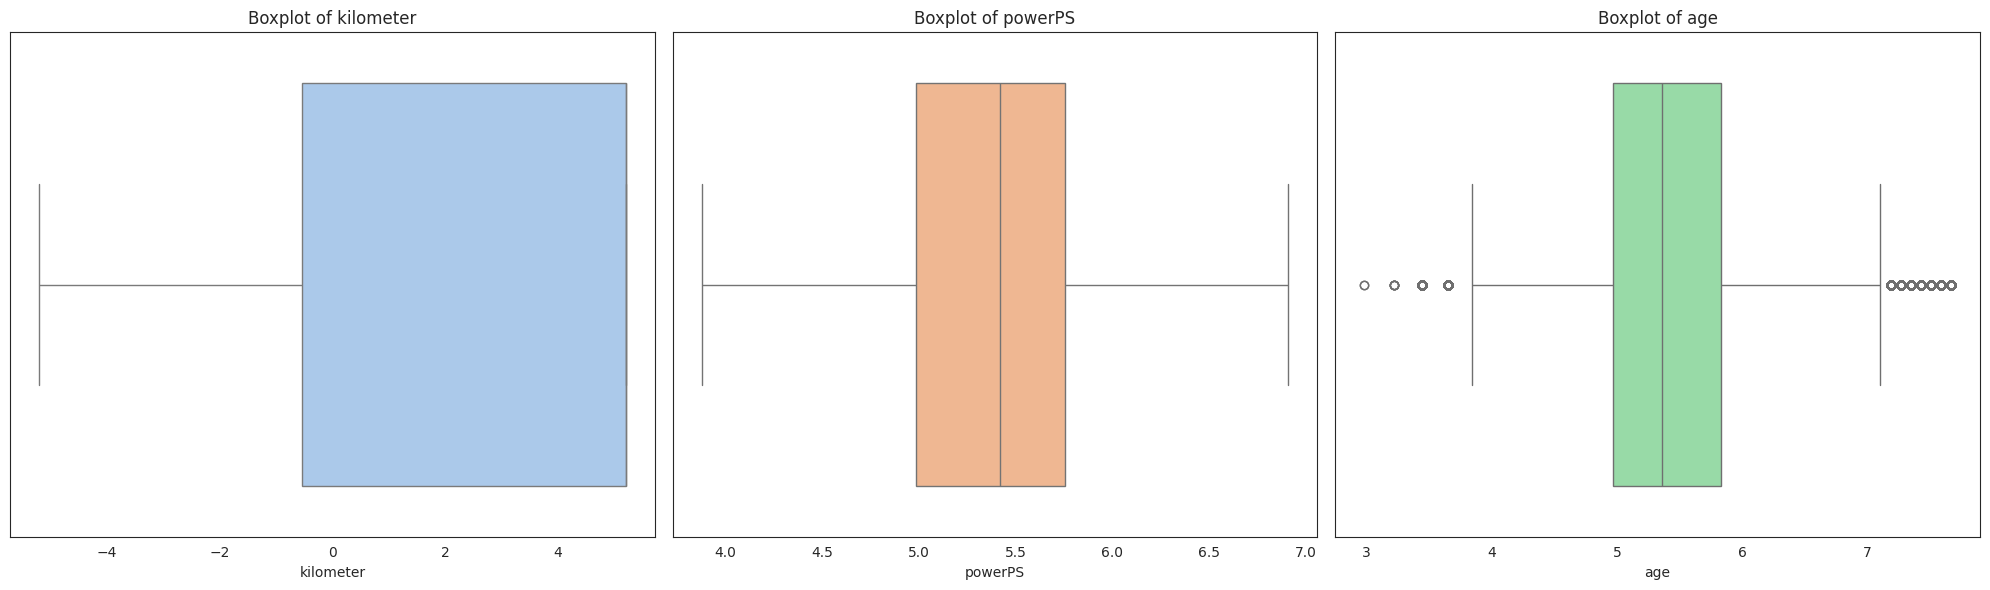

In [247]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), tight_layout=True)
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

for i, column in enumerate(numerical_features):
    sns.boxplot(x=df_test[column], ax=axes[i], color=color_palette[i])
    axes[i].set_title(f"Boxplot of {column}")
    axes[i].set_xlabel(column)

plt.show()

In [248]:
df_test.to_csv("../data/processed/data.csv", index=False)

# Modeling

## In this phase, I'm going to train different models in order to predict the price of a used car based on other features. I plan to use:
#### - Conventional ML methods for regression
#### - Ensembling

## **Machine learning**
- **Regression Models:** Decision Tree, Random Forest, Extra Trees, AdaBoost, XGBoost, CatBoost, and KNeighbors
- **Metrics:** MSE, MAE, and $R^2\textrm{-}Score$
- Cross-validation


In [306]:
models = {
    "Linear Regression": LinearRegression(),
    # 'KNN': KNeighborsRegressor(weights='distance'),
    "XGBoost": XGBRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
}

In [263]:
scoring = {"R2": make_scorer(r2_score), "MAE": make_scorer(mean_absolute_error), "MSE": make_scorer(mean_squared_error)}

In [260]:
X = df_test.drop(["price"], axis=1)
y = df_test["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
print(f"Train Shape: {X_train.shape}\nTest Shape: {X_test.shape}")

Train Shape: (183464, 10)
Test Shape: (45866, 10)


In [268]:
df_dummies = pd.get_dummies(df_test, drop_first=True)
print(f"Shape of the DataFrame with Dummies: {df_dummies.shape}")
df_dummies.head()

Shape of the DataFrame with Dummies: (229330, 305)


,price,abtest,gearbox,powerPS,kilometer,notRepairedDamage,age,vehicleType_convertible,vehicleType_coupe,vehicleType_other,vehicleType_sedan,vehicleType_small car,vehicleType_station wagon,vehicleType_suv,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_andere,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_citigo,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_evoque,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_serie_2,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_lpg,fuelType_other,fuelType_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
3,1500,1,0,4.872407,5.199338,0,5.719271,False,False,False,False,True,False,False,False,False,False,False,False,False,False,Fals

In [303]:
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("pca", PCA(n_components=0.95)),
    ]
)

## Test for number of components to achieve 95% of variance explained

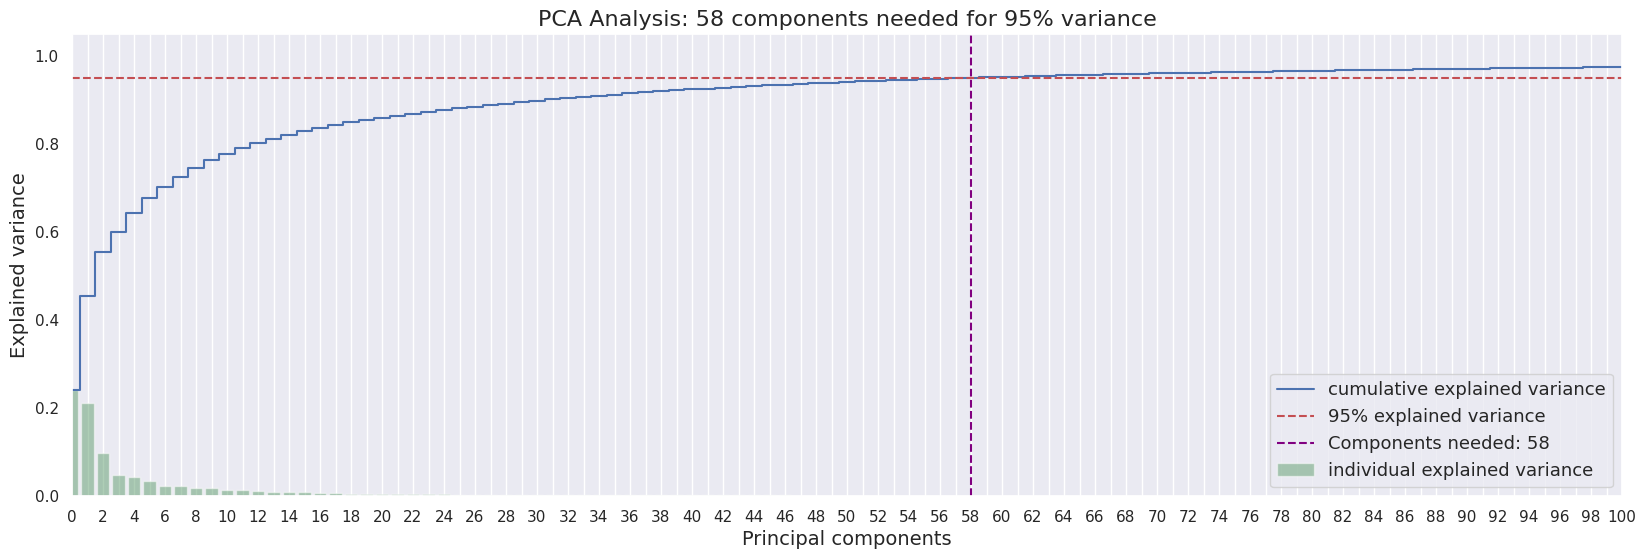

In [ ]:
X_transformed = final_pipeline.fit_transform(X_train)
pca = PCA().fit(X_transformed)

cumulative_variance = pca.explained_variance_ratio_.cumsum()
# Find where variance exceeds 95%
components_95pct = next(i for i, var in enumerate(cumulative_variance) if var >= 0.95)

fig, ax = plt.subplots(figsize=(20, 6))
sns.set(font_scale=1)

# Plot cumulative variance
plt.step(range(X_transformed.shape[1]), cumulative_variance, where="mid", label="cumulative explained variance")

# Plot individual variance
sns.barplot(pca.explained_variance_ratio_, alpha=0.5, color="g", label="individual explained variance")

plt.xlim(0, 100)

# Add horizontal line at 95% variance
plt.axhline(y=0.95, color="r", linestyle="--", label="95% explained variance")

# Add vertical line at number of components needed for 95% variance
plt.axvline(x=components_95pct, color="purple", linestyle="--", label=f"Components needed: {components_95pct}")

ax.set_xticklabels([s if int(s.get_text()) % 2 == 0 else "" for s in ax.get_xticklabels()])

plt.ylabel("Explained variance", fontsize=14)
plt.xlabel("Principal components", fontsize=14)
plt.legend(loc="best", fontsize=13)
plt.title(f"PCA Analysis: {components_95pct} components needed for 95% variance", fontsize=16)
plt.grid()

So, we need keep 58 components to achieve 95% of variance explained

In [305]:
results = {
    "Model": [],
    "R2 (Test)": [],
    "MAE (Test)": [],
    "MSE (Test)": [],
    "Score Time": [],
    "R2 (Train)": [],
    "MAE (Train)": [],
    "MSE (Train)": [],
    "Train Time": [],
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Cross validate {name}...")

    model_pipeline = Pipeline(steps=[("final_pipeline", final_pipeline), ("model", model)])

    cv_results = cross_validate(model_pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1, return_train_score=True)
    print("_" * 50)

    results["Model"].append(name)
    results["R2 (Test)"].append(cv_results["test_R2"].mean())
    results["MAE (Test)"].append(cv_results["test_MAE"].mean())
    results["MSE (Test)"].append(cv_results["test_MSE"].mean())
    results["Score Time"].append(cv_results["score_time"].mean())

    results["R2 (Train)"].append(cv_results["train_R2"].mean())
    results["MAE (Train)"].append(cv_results["train_MAE"].mean())
    results["MSE (Train)"].append(cv_results["train_MSE"].mean())
    results["Train Time"].append(cv_results["fit_time"].mean())

print("Cross validating completed.")

Cross validate Linear Regression...


/home/minhquana/workspace/learning/used-car-price-prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/minhquana/workspace/learning/used-car-price-prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


__________________________________________________
Cross validate KNN...


/home/minhquana/workspace/learning/used-car-price-prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/minhquana/workspace/learning/used-car-price-prediction/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="R2", ascending=False)

In [ ]:
fit_results = {
    "Model": [],
    "R-squared (Test)": [],
    "MAE (Test)": [],
    "MSE (Test)": [],
    "R-squared (Train)": [],
    "MAE (Train)": [],
    "MSE (Train)": [],
}

for name, model in models.items():
    print(f"Fitting {name}...")

    model_pipeline = Pipeline(steps=[("final_pipeline", final_pipeline), ("model", model)])

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    r2_test = r2_score(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)

    fit_results["Model"].append(name)
    fit_results["R-squared (Test)"].append(r2_test)
    fit_results["MAE (Test)"].append(mae_test)
    fit_results["MSE (Test)"].append(mse_test)

    y_train_pred = model_pipeline.predict(X_train)
    fit_results["R-squared (Train)"].append(r2_score(y_train, y_train_pred))
    fit_results["MAE (Train)"].append(mean_absolute_error(y_train, y_train_pred))
    fit_results["MSE (Train)"].append(mean_squared_error(y_train, y_train_pred))

print("Fitting completed.")
fit_results_df = pd.DataFrame(fit_results)

# **Hyperparameter Tuning**
- **RandomizedSearchCV**
- **GridSearchCV**

In [ ]:
param_distributions = {
    "KNN": {"n_neighbors": [5, 10, 20], "weights": ["uniform", "distance"]},
    "XGBoost": {"n_estimators": [100, 300, 500, 800, 1000], "max_depth": [3, 5, 7]},
    "Random Forest": {"n_estimators": [100, 300, 500, 800, 1000], "max_depth": [3, 5, 7]},
    "Extra Trees": {"n_estimators": [100, 300, 500, 800, 1000], "max_depth": [3, 5, 7]},
}

In [ ]:
best_models = {}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"Hyperparameter tuning for {name}...")

    random_search = RandomizedSearchCV(
        model, param_distributions[name], n_iter=10, scoring="r2", n_jobs=-1, cv=5, verbose=1
    )